This notebook displays our model result from 2002 to 2007.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*sub*2007*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))

found *.nc file: 
["/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/subset_['T200201-200712.nc'].nc"]


In [2]:
ptrc=nc.Dataset(nc_filename[0])

lon=ptrc.variables['nav_lon'][:]
lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]




bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]


In [3]:
#take a look at the time dimension
diss=ptrc.variables['TR_11'][:,0,220,270]
tlen=diss.shape
print tlen[0]
print diss

72
[ 0.99362862  0.99808735  0.99788141  0.98130238  0.98348325  0.96339875
  0.88051003  0.79526258  0.83482194  0.95622778  0.98187798  0.98065907
  0.98931754  0.99697518  0.9982605   0.99648958  0.9883585   0.98113614
  0.9241116   0.71784824  0.71929276  0.94924438  0.97423577  0.98980093
  0.99889213  0.99668688  0.99420184  0.9965682   0.99525714  0.98088843
  0.85488075  0.80679297  0.83177119  0.97429299  0.99132329  0.98914891
  0.99426818  0.98942643  0.99136877  0.99100542  0.98880035  0.99530727
  0.96281368  0.96552616  0.94329584  0.9890607   0.97415388  0.98577875
  0.99887401  0.99668688  0.99420184  0.9965682   0.99525714  0.98088843
  0.85488075  0.80679297  0.83177119  0.97429299  0.99132329  0.98914891
  0.99426818  0.98942643  0.99136877  0.99100542  0.98880035  0.99530727
  0.96281368  0.96552616  0.94329584  0.9890607   0.97415388  0.98577875]


### Focus on the time evolution

In [8]:
def readdata(phase,string,i,a1,a2,b1,b2):
    if string =='Pa':
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_7'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_7'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_9'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_9'][:,i,a1:a2,b1:b2]
    else:
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_8'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_8'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_10'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_10'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data




def readice(string,i,x,y):
    if i ==0:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,:,x,y]
        else:
                data=ptrc.variables['TR_12'][:,:,x,y]
    else:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,i,x,y]
        else:
                data=ptrc.variables['TR_12'][:,i,x,y]
    if string =='deso':
        Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
        data=Dsopt.variables['desorption_rate'][:,x,y]
    data=np.ma.masked_where(data<0,data)
    return data

def analy(string,phase,i,a,b,ice):
        if string=='Pa':
            k=-0.0005*100*ice[i]+0.06
            if phase=='part':
                    analy=0.00246/(6.01*100*ice[i]+500)*dep[i]                    
            else:
                analy=0.00246/k+0.31/k*0.00246/(6.01*100*ice[i]+500)*dep[i]
        if string=='Th':
            k=-0.0067*100*ice[i]+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        return analy

def tracer_evolution(ptrc,j,string,name):
    
    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(3, 3)
    
    ax = fig.add_subplot(gs[0:2,0])
    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
    #x=[700,630,600]
    #y=[200,300,350]
    #c=['orange','red','cyan']
    x_lon,y_lat = m(lon,lat)
    plt.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
    #m.scatter(x_lon[x,y],y_lat[x,y],color=c,s=40,alpha=0.8)
    m.plot(x_lon[660-400,250:300],y_lat[660-400,250:300],color='orange')
    m.plot(x_lon[615-400:650-400,305],y_lat[615-400:650-400,306],color='red')
    
    #evaluation   
    elat=np.array([83.114,   87.623  ]) #     83°06.826 87°37.375 N  
    elon=np.array([-174.88,  156.09  ]) #   174°52.689W 156°05.581 E
    e_lon,e_lat = m(elon,elat)
    m.scatter(e_lon,e_lat,marker='+',color='red',s=60)
    
    m = m.contour(x_lon,y_lat,bathy,linewidth=0.05,colors='black',alpha=0.2)
    plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')
    


    
    
    ax = fig.add_subplot(gs[0,1])
    i=j[0]
    for loc in range (len(x)):
        data=readdata('diss','Th',i=0,a1=660-400,a2=661-400,b1=250,b2=300)\
            +readdata('part','Th',i=0,a1=660-400,a2=661-400,b1=250,b2=300)
        plt.pcolor(lat[660-400,250:300],dep[lmin:lmax],data[-1,lmin:lmax,0,:],alpha=0.5)
    plt.colorbar()
    y0=np.array([20.1,100.0,292.5,491.3,691.5,1091.5,1290.9,1491.4,1691.5,1891.1,2092.1,2290.9,2480.4,2692.2])
    x0=np.array([0.23097531,0.3115801186,0.5066939254,0.6922778619,0.6283046556,0.7627209815,0.7814033969,
        1.0046730342,0.9339497418,1.096588395,1.1791569817,1.2986671687,1.3412285366,1.6945276994])
    lats=np.zeros(len(y0))
    #print len(y0),lats.shape
    lats[:]=elat[0]
    
    plt.scatter(lats[:],y0,c=x0,vmin=np.min(data[-1,lmin:lmax,0,:]),
                vmax=np.max(data[-1,lmin:lmax,0,:]),s=40)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    plt.title('%s'%(name[0]))
    
    
#!!!here    
    ax = fig.add_subplot(gs[0,2])
    i=j[0]
    plt.plot(x0,y0,'--',lw=2,label='data')

    
    ice=readice('Th',i=0,x=660-400,y=270)
    ana=np.zeros(len(data[0,:,0,0]))
    for z in range (len(data[0,:,0,0])):
        ana[z]   =analy('Th','diss',i=z,a=660-400,b=270,ice=ice[-1,:])\
                 +analy('Th','part',i=z,a=660-400,b=270,ice=ice[-1,:])
    #print ana.shape
    plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')
    
    #pay attention to the index
    for i in range (len(data[:,0,0,0])):
        plt.plot(data[i,lmin:lmax,0,20],dep[lmin:lmax],lw=2)#,label='simulation')     
    plt.ylim([500,3500])
    plt.gca().invert_yaxis()
    plt.title('%s'%(name[0]))
    plt.legend()
    
    
    ax = fig.add_subplot(gs[1,1])
    i=j[0]
    for loc in range (len(x)):
        data=readdata('diss','Th',i=0,a1=615-400,a2=650-400,b1=305,b2=306)\
            +readdata('part','Th',i=0,a1=615-400,a2=650-400,b1=305,b2=306)
        #print lat[615-400:650-400,300].shape,data[-1,lmin:lmax,:,0].shape
        plt.pcolor(lat[615-400:650-400,300],dep[lmin:lmax],data[-1,lmin:lmax,:,0],alpha=0.5)
    plt.colorbar()
    y0=np.array([2.2,20.5,127.0,258.2,408.8,610.4,913.6,1217.6,1523.3,1830.4,
     2138.6,2441.3,2752.3,3062.9,3720.8,4028.6])
    x0=np.array([0.2408122073,0.2612594506,0.4828673279,0.9891112582,0.7759438555,0.8382833503,0.9810394531,
     1.2535573266,1.5174676222,1.7516785761,1.9769771391,1.9348387143,1.9717981823,2.1756327796,2.4095804438,2.4280244504])
    lats2=np.zeros(len(y0))
    lats2[:]=elat[1]
    
    plt.scatter(lats2[:],y0,c=x0,vmin=np.min(data[-1,lmin:lmax,:,0]),
                vmax=np.max(data[-1,lmin:lmax,:,0]),s=40)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    plt.title('%s'%(name[0]))

    ax = fig.add_subplot(gs[1,2])
    i=j[0]
    plt.plot(x0,y0,'--',lw=2,label='data')
    
    ice=readice('Th',i=0,x=650-400,y=305)
    for z in range (len(data[0,:,0,0])):
        ana[z]   =analy('Th','diss',i=z,a=650-400,b=305,ice=ice[-1,:])\
                 +analy('Th','part',i=z,a=650-400,b=305,ice=ice[-1,:])
    #print ana.shape
    plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')
    
    
    for i in range (len(data[:,0,0,0])):
        plt.plot(data[i,lmin:lmax,5,0],dep[lmin:lmax],lw=2)#,alpha=np.float(i)/len(data[:,0,0,0]),label='simulation')#pay atten to the index
    plt.ylim([500,3500])
    plt.gca().invert_yaxis()
    plt.title('%s'%(name[0]))
    plt.legend()
    
    plt.show()

# 2002-2007

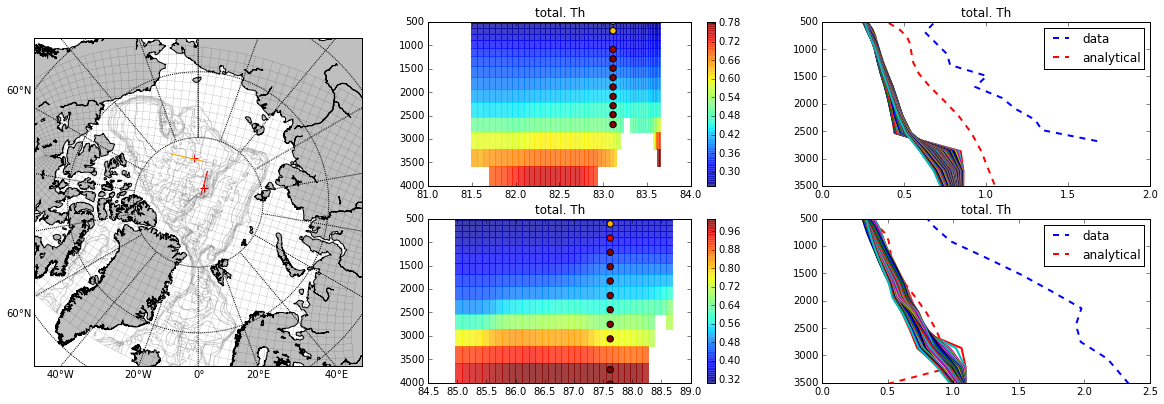

In [9]:
from matplotlib import gridspec
x=[660-400,625-400]
y=[280,310]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])

lmin=30
lmax=46
tracer_evolution(ptrc,j=[35,40,43],string='Th',name=['total. Th','part. Th'])

If the value of desorption rates are multiplied by 2.Here is the result.

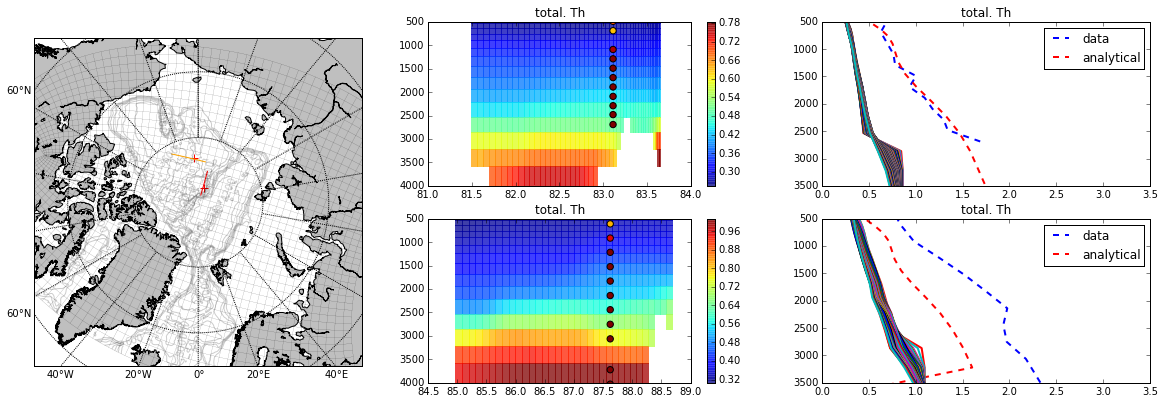

In [86]:
from matplotlib import gridspec
x=[660-400,625-400]
y=[280,310]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])

lmin=30
lmax=46
tracer_evolution(ptrc,j=[35,40,43],string='Th',name=['total. Th','part. Th'])

HLY0503-18TC from the Healy–Oden Trans-Arctic Expedition of 2005

1. total
2. without error bar